In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fpath = '../../resources/tunahan/Mathys_SC_iMAT/SC_astrocyte_iMAT_binary_models_10.04.22.txt'
imat = pd.read_csv(fpath, header=None).values

In [3]:
fpath = '../../resources/tunahan/Mathys_SC_iMAT/SC_astrocyte_metadata_10.04.22.xlsx'
df = pd.read_excel(fpath, dtype=pd.Categorical)

Note that `SC_astrocyte_metadata_10.04.22.xlsx` in the original `Mathys_SC_iMAT.rar` had no headers.  This was fixed manually.

In [4]:
def read_imat(celltype='astrocyte'):
    imatpath = '../../resources/tunahan/Mathys_SC_iMAT/SC_' + celltype + '_iMAT_binary_models_10.04.22.txt'
    metapath = '../../resources/tunahan/Mathys_SC_iMAT/SC_' + celltype + '_metadata_10.04.22.xlsx'
    meta = pd.read_excel(metapath, dtype='category')
    meta = meta.rename(dict(zip(meta.index, meta.SampleID)))
    meta['Subject'] = meta.SampleID.str.split('.').apply(lambda x: x[1])
    imat = pd.read_csv(imatpath, header=None).values.transpose()
    imat = pd.DataFrame(imat, index=meta.SampleID)
    val = pd.concat([meta.drop(['ProjID', 'SampleID'], axis=1), imat], axis=1)
    return(val)

celltypes = ['astrocyte', 'exneuron', 'microglia']
imat = {c: read_imat(c) for c in celltypes}

An order of magnitude more exneuron nuclei were sequenced than astrocyte or microglia nuclei.

In [5]:
{k: i.shape for k, i in imat.items()}

{'astrocyte': (3292, 13073),
 'exneuron': (33335, 13073),
 'microglia': (1844, 13073)}

In [6]:
astrocyte = imat['astrocyte']
astrocyte

,CeradScore,Condition,Subject,0,1,2,3,4,5,6,...,13060,13061,13062,13063,13064,13065,13066,13067,13068,13069
AAACGGGAGGCTCTTA.2,1,AD,2,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AACCATGCACTGTTAG.2,1,AD,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
AGTAGTCTCTGGCGAC.2,1,AD,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
CAGCTAATCATAAAGG.2,1,AD,2,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,1
CGGACACGTAGCGCAA.2,1,AD,2,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTGTTAGGTGCACGAA.47,4,CTRL,47,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
TCATTTGGTCTGGTCG.47,4,CTRL,47,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,1
TGCGGGTTCTTATCTG.47,4,CTRL,47,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
TTAGGCATCAGCTCGG.47,4,CTRL,47,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,1


['named-figure/imat-std-within-across-subjects.png',
 'named-figure/imat-std-within-across-subjects.pdf']

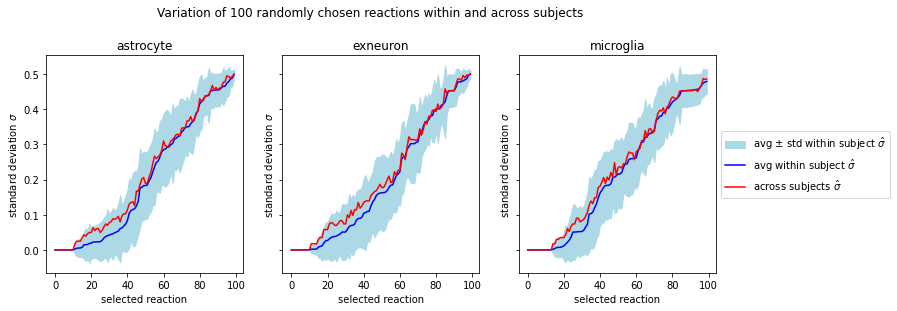

In [24]:
def get_std(reaction=0, df=imat['astrocyte'], within_subj=True):
    val = df.groupby('Subject')[reaction].std() if within_subj else df[reaction].std()
    return(val)


def plot_std(ax, celltype='astrocyte', ssize=100, dolabel=False):
    df = imat['astrocyte']
    all_reactions = df.drop(['CeradScore', 'Condition', 'Subject'], axis=1).columns
    reactions = np.random.choice(all_reactions, size=ssize, replace=False)
    std_across_mean = np.array([get_std(r, df=df, within_subj=False) for r in reactions])
    std_within_mean = np.array([get_std(r, df=df, within_subj=True).mean() for r in reactions])
    std_within_std = np.array([get_std(r, df=df, within_subj=True).std() for r in reactions])
    sortix = np.argsort(std_within_mean)
    y1 = std_within_mean[sortix] - std_within_std[sortix]
    y2 = std_within_mean[sortix] + std_within_std[sortix]
    ax.fill_between(range(len(reactions)), y1, y2, color='lightblue', label=r'avg $\pm$ std within subject $\hat{\sigma}$' if dolabel else None)
    ax.plot(range(len(reactions)), std_within_mean[sortix], color='blue', label=r'avg within subject $\hat{\sigma}$' if dolabel else None)
    ax.plot(range(len(reactions)), std_across_mean[sortix], color='red', label=r'across subjects $\hat{\sigma}$' if dolabel else None)
    ax.set_title(celltype)
    ax.set_xlabel('selected reaction')
    ax.set_ylabel(r'standard deviation $\sigma$')
    return(ax)

fig, ax = plt.subplots(1, len(imat), figsize=(12, 4), sharey=True)
for i, var in enumerate(zip(ax, imat.keys())):
    axi, ct = var
    plot_std(axi, celltype=ct, dolabel=i == 0)

fig.legend(loc='center left', bbox_to_anchor=(0.90, 0.50))
fig.suptitle('Variation of 100 randomly chosen reactions within and across subjects', y=1.05)

attila_utils.savefig(fig, 'imat-std-within-across-subjects')

In [8]:
%connect_info

{
  "shell_port": 56594,
  "iopub_port": 56595,
  "stdin_port": 56596,
  "control_port": 56598,
  "hb_port": 56597,
  "ip": "127.0.0.1",
  "key": "8e73451d-df848c803889a3ef1ced2254",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9645b9ce-9664-4ea2-b5d2-66f6c47e4aa4.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
